Here, we will use the open dataset crawled from Airbnb website, containing the Listings.csv, including the full housing description and corresponding average review score accompanied by the unique id for housing, and Reviews.csv, including the unique id for reviewers and detailed comments. Source: https://www.kaggle.com/airbnb/seattle.

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 7.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=b39840540793155dbd599f10fbdca50d395af6e1c73e913c904d5b1962bee497
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser

from pandas import Series, DataFrame
import seaborn as sns

import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data prepared for collaborative filtering
reviews=pd.read_csv('/content/drive/Shareddrives/FML-Recommender project/Seattle Airbnb DATA/Seattle Airbnb/reviews.csv')
listing=pd.read_csv('/content/drive/Shareddrives/FML-Recommender project/Seattle Airbnb DATA/Seattle Airbnb/listings.csv')

In [ ]:
listing.shape #We have 3818 records of Seattle airnbnb housing in total

(3818, 92)

In [ ]:
listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [ ]:
reviews.shape # we have 84849 reviews in total

(84849, 6)

In [ ]:
reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
reviews['reviewer_id'].nunique()

75730

In [ ]:
# data prepare for content-based recommender
df_label = pd.read_csv('/content/drive/Shareddrives/FML-Recommender project/Seattle Airbnb DATA/Seattle Airbnb/listings.csv' , usecols = ['id', 'name' , 'host_id' , 'host_response_time' ,
 'host_response_rate' , 'host_is_superhost' , 'host_verifications' , 
 'host_identity_verified' , 'street' , 'neighbourhood_group_cleansed' , 'is_location_exact', 
 'property_type' , 'room_type' , 'accommodates' , 'bathrooms' , 'bedrooms' , 'beds',
 'amenities' , 'price' , 'cleaning_fee' , 'guests_included' , 'extra_people',
 'minimum_nights' , 'maximum_nights' , 'calendar_updated' , 
 'availability_30' , 'availability_60' , 'availability_90' , 'availability_365',
 'number_of_reviews' , 'review_scores_rating' , 'review_scores_accuracy',
 'review_scores_cleanliness' , 'review_scores_checkin', 
 'review_scores_communication' , 'review_scores_location', 
 'review_scores_value' , 'requires_license' ,  'instant_bookable' , 'cancellation_policy' , 'require_guest_profile_picture',
 'require_guest_phone_verification' ,  'reviews_per_month'])

features = ['host_response_time' , 'host_response_rate' , 'host_is_superhost' , 'host_verifications' , 
 'host_identity_verified' , 'street' , 'neighbourhood_group_cleansed' , 'is_location_exact', 
 'property_type' , 'room_type' , 'accommodates' , 'bathrooms' , 'bedrooms' , 'beds',
 'amenities' , 'price' , 'cleaning_fee' , 'guests_included' , 'extra_people',
 'minimum_nights' , 'maximum_nights' , 'calendar_updated' , 
 'availability_30' , 'availability_60' , 'availability_90' , 'availability_365',
 'number_of_reviews' , 'review_scores_rating' , 'review_scores_accuracy',
 'review_scores_cleanliness' , 'review_scores_checkin', 
 'review_scores_communication' , 'review_scores_location', 
 'review_scores_value' , 'requires_license' ,  'instant_bookable' , 
 'cancellation_policy' , 'require_guest_profile_picture',
 'require_guest_phone_verification' ,  'reviews_per_month']
df = df_label[features]
df1 = pd.read_csv('/content/drive/Shareddrives/FML-Recommender project/Seattle Airbnb DATA/Seattle Airbnb/listings.csv')
print(df1)


            id  ... reviews_per_month
0       241032  ...              4.07
1       953595  ...              1.48
2      3308979  ...              1.15
3      7421966  ...               NaN
4       278830  ...              0.89
...        ...  ...               ...
3813   8101950  ...              0.30
3814   8902327  ...              2.00
3815  10267360  ...               NaN
3816   9604740  ...               NaN
3817  10208623  ...               NaN

[3818 rows x 92 columns]


# Content-Based Recommender

## TF.IDF based (recommendation based on similarity of housing titles)

The formal measure of how concentrated into relatively few documents are
the occurrences of a given word is called TF.IDF (Term Frequency times Inverse Document Frequency). TF.IDF is in essence a weight factor. TF-IDF method has been used in a lot of domains (sentiment analysis, RS, stop words filterin etc.) This method is divided into two. Fistly we will analyze Term Frequency(TF).

### Initialization

In [ ]:
name_corpus = ' '.join(listing['name'])
description_corpus = ' '.join(listing['description'])

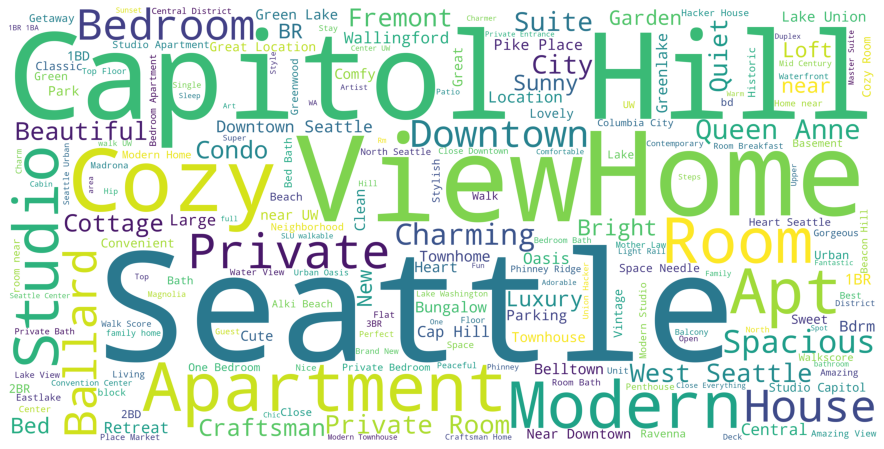

In [ ]:
name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(name_corpus)
plt.figure(figsize = (16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

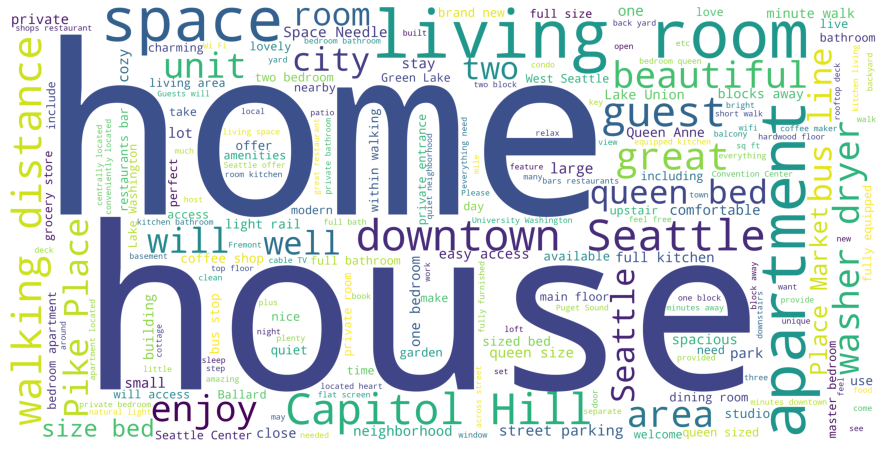

In [ ]:
description_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', height = 2000, width = 4000).generate(description_corpus)
plt.figure(figsize = (16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
listing.info()

In [ ]:
listu = pd.read_csv('/content/drive/Shareddrives/FML-Recommender project/Seattle Airbnb DATA/Seattle Airbnb/listings.csv', usecols = ['id', 'name', 'property_type' ,'description' ,'room_type' ,'bed_type' ,'amenities'])
listu.head(10)

,id,name,description,property_type,room_type,bed_type,amenities
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,Apartment,Entire home/apt,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ..."
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,House,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,House,Private room,Real Bed,"{""Wireless Internet"",""Free Parking on Premises..."
6,1909058,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,House,Private room,Real Bed,"{""Wireless Internet"",""Free Parking on Premises..."
7,856550,Tiny Garden cabin on Queen Anne,"Our tiny cabin is private , very quiet and com...",Cabin,Private room,Real Bed,"{""Wireless Internet"",""Pets live on this proper..."
8,4948745,Urban Charm || Downtown || Views,"Nestled in the heart of the city, this space i...",Apartment,Private room,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
9,2493658,Airy + Bright Queen Anne Apartment,"Beautiful apartment in an extremely safe, quie...",Apartment,Entire home/apt,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free..."


In [ ]:
listu['room_type'] = [re.sub(r'[^\w\s]', ' ', t) for t in listu['room_type']]
listu['description'] = [re.sub(r'[^\w\s]', ' ', t) for t in listu['description']]
listu['amenities'] = [re.sub(r'[^\w\s]', ' ', t) for t in listu['amenities']]
listu['name'] = [re.sub(r'[^\w\s]', ' ', t) for t in listu['name']]
listu['bed_type'] = [re.sub(r'[^\w\s]', ' ', t) for t in listu['bed_type']]

listu['room_type'] = [t.lower() for t in listu['room_type']]
listu['description'] = [t.lower() for t in listu['description']]
listu['amenities'] = [t.lower() for t in listu['amenities']]
listu['name'] = [t.lower() for t in listu['name']]
listu['bed_type'] = [t.lower() for t in listu['bed_type']]

In [ ]:
listu.head()

,id,name,description,property_type,room_type,bed_type,amenities
0,241032,stylish queen anne apartment,make your self at home in this charming one be...,Apartment,entire home apt,real bed,tv cable tv internet wireless internet a...
1,953595,bright airy queen anne apartment,chemically sensitive we ve removed the irrita...,Apartment,entire home apt,real bed,tv internet wireless internet kitchen free...
2,3308979,new modern house amazing water view,new modern house built in 2013 spectacular s...,House,entire home apt,real bed,tv cable tv internet wireless internet a...
3,7421966,queen anne chateau,a charming apartment that sits atop queen anne...,Apartment,entire home apt,real bed,internet wireless internet kitchen indoor ...
4,278830,charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...,House,entire home apt,real bed,tv cable tv internet wireless internet ki...


In [ ]:
listu.fillna('null', inplace = True)
listu["combined"] = listu['description'] + '  ' + listu['property_type'] + ' ' + listu['room_type'] + ' ' + listu['bed_type'] + ' ' + listu['amenities'] 
listu.drop(["description","property_type","room_type","bed_type","amenities"],axis=1,inplace=True)
listu.head(10)


,id,name,combined
0,241032,stylish queen anne apartment,make your self at home in this charming one be...
1,953595,bright airy queen anne apartment,chemically sensitive we ve removed the irrita...
2,3308979,new modern house amazing water view,new modern house built in 2013 spectacular s...
3,7421966,queen anne chateau,a charming apartment that sits atop queen anne...
4,278830,charming craftsman 3 bdm house,cozy family craftman house in beautiful neighb...
5,5956968,private unit in a 1920s mansion,we re renting out a small private unit of one ...
6,1909058,queen anne private bed and bath,enjoy a quiet stay in our comfortable 1915 cra...
7,856550,tiny garden cabin on queen anne,our tiny cabin is private very quiet and com...
8,4948745,urban charm downtown views,nestled in the heart of the city this space i...
9,2493658,airy bright queen anne apartment,beautiful apartment in an extremely safe quie...


In [ ]:
# Content Similarity
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(listu["combined"])
cosine_similarities = linear_kernel(matrix,matrix)
book_title = listu['name']
indices = pd.Series(listu.index, index=listu['name'])

### Set up model

In [ ]:
def content_recommender(title):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_similarities[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:31]
  book_indices = [i[0] for i in sim_scores]
  return book_title.iloc[book_indices]

In [ ]:
# Make a recommendation, based on listings' titles
content_recommender('new modern house amazing water view').head(10)

25            view monthly rental available
19       grand craftsman home on queen anne
2518    fabulous views of lakes   mountains
989     madrona urban oasis views   space  
3708             fremont single family home
1894           modern home in west seattle 
2364    steps to lake washington 3 bed 2 ba
252     2 bedroom   2 bath  large deck view
295          charming wallingford apartment
2363     spacious family home close to lake
Name: name, dtype: object

## Feature-based (Find the most similar house based on their attributes)

### Data Visualisation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


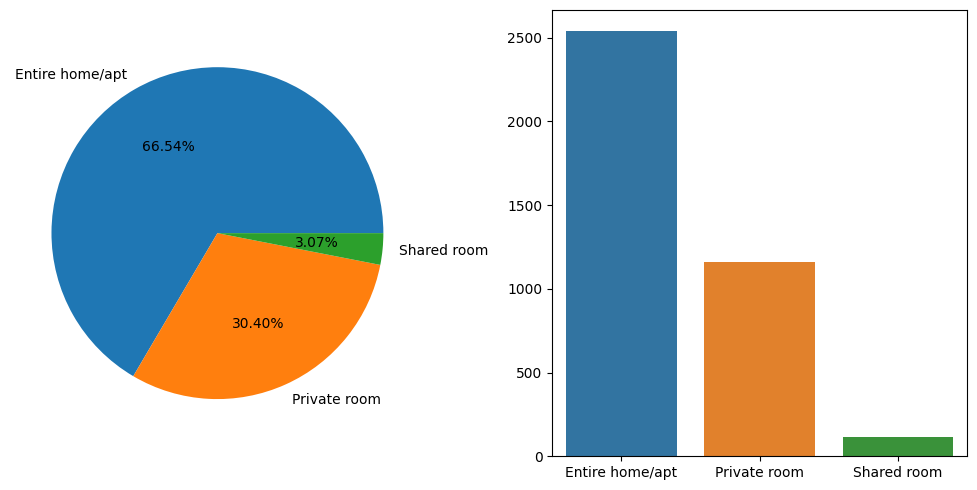

In [ ]:
#neighbourhood_group_cleansed
# Room Type
room_type_counts = df['room_type'].value_counts()
fig,axes = plt.subplots(1,2,figsize=(10,5), dpi=100)
axes[0].pie(room_type_counts.values,autopct="%.2f%%",labels=room_type_counts.index)
sns.barplot(room_type_counts.index,room_type_counts.values)
plt.tight_layout()


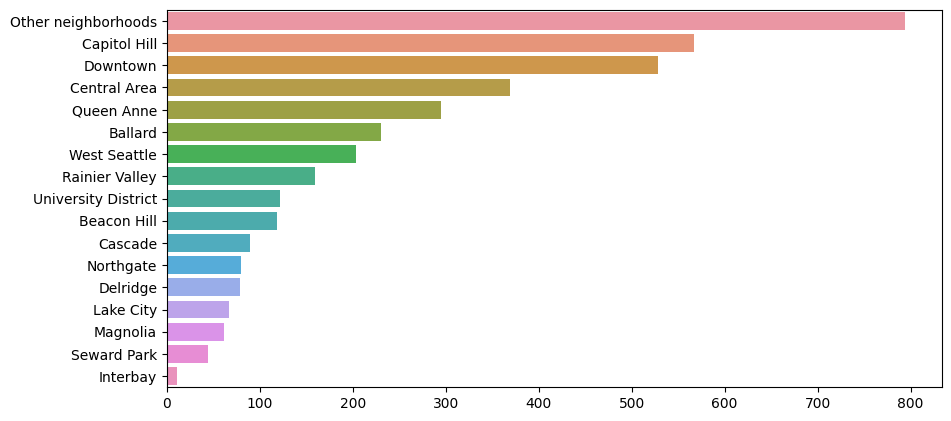

In [ ]:
# Geography
plt.figure(figsize=(10, 5), dpi=100)
neighbourhood_counts = df['neighbourhood_group_cleansed'].value_counts()
sns.barplot(y=neighbourhood_counts.index,x=neighbourhood_counts.values,orient='h')
plt.show()


In [ ]:
# distribution of different room type in different areas
neighbour_room_type = df.groupby(['neighbourhood_group_cleansed','room_type']) \
    .size() \
    .unstack('room_type') \
    .fillna(0) \
    .apply(lambda row: row/row.sum(),axis=1) \
    .sort_values("Entire home/apt",ascending=True)
neighbour_room_type


room_type,Entire home/apt,Private room,Shared room
neighbourhood_group_cleansed,,,
Interbay,0.454545,0.545455,0.000000
Lake City,0.462687,0.537313,0.000000
Rainier Valley,0.477987,0.496855,0.025157
Beacon Hill,0.483051,0.491525,0.025424
Northgate,0.512500,0.437500,0.050000
Delridge,0.518987,0.481013,0.000000
University District,0.606557,0.311475,0.081967
Central Area,0.609756,0.379404,0.010840
Seward Park,0.613636,0.386364,0.000000


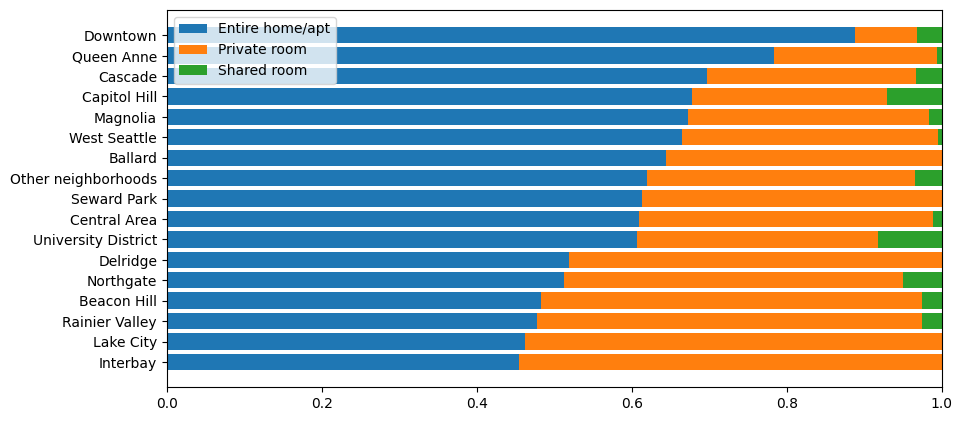

In [ ]:
# Type distribution bar plot
columns = neighbour_room_type.columns
plt.figure(figsize=(10, 5), dpi=100)
index = neighbour_room_type.index
plt.barh(index,neighbour_room_type[columns[0]])
left = neighbour_room_type[columns[0]].copy()
plt.barh(index,neighbour_room_type[columns[1]],left=left)
left += neighbour_room_type[columns[1]].copy()
plt.barh(index,neighbour_room_type[columns[2]],left=left)
left += neighbour_room_type[columns[2]].copy()
plt.legend(columns)
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


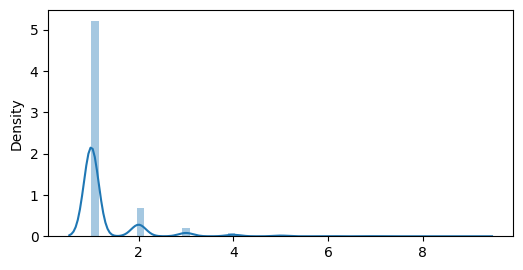

In [ ]:
# Analyze hosts with more than one properties
plt.figure(figsize=(6, 3), dpi=100)
host_number = df.groupby('host_id').size()
sns.distplot(host_number[host_number<10])
plt.show()

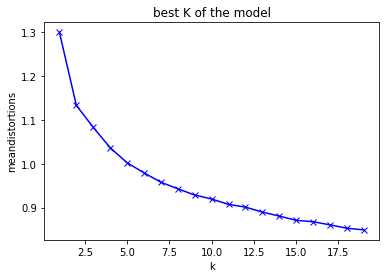

In [ ]:
# choose k for k-means
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
K = range(1, 20)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(feature_array)
    meandistortions.append(sum(np.min(cdist(feature_array, kmeans.cluster_centers_, 'euclidean'), axis=1)) / feature_array.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('meandistortions')
plt.title('best K of the model');
plt.show()
n_clusters = 7


### Transfer Features

In [ ]:
from numpy.core.numeric import NaN
# transfer ['host_response_time'] to int
df['host_response_time'] = pd.factorize(df['host_response_time'])[0].astype(np.uint16)

#df['host_response_rate']
df['host_response_rate'] = df['host_response_rate'].str.strip("%").astype(float)/100
m = df['host_response_rate'].median()
#df['host_response_rate'].fillna(m)
df['host_response_rate'] = df['host_response_rate'].fillna(m)


#transfer df['host_is_superhost'] to int
df['host_is_superhost'] = pd.factorize(df['host_is_superhost'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#replace df['host_verifications'] with number of verification method 
df['host_verifications'] = df['host_verifications'].str[1:-1].str.split(",").apply(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#transfer df['host_identity_verified'] to int
df['host_identity_verified'] = pd.factorize(df['host_identity_verified'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#df['street']
df['street'] = pd.factorize(df['street'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#df['neighbourhood_group_cleansed']
df['neighbourhood_group_cleansed'] = pd.factorize(df['neighbourhood_group_cleansed'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#df['is_location_exact']
df['is_location_exact'] = pd.factorize(df['is_location_exact'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#df['property_type']
df['property_type'] = pd.factorize(df['property_type'])[0].astype(np.uint16)
#df['room_type']
df['room_type'] = pd.factorize(df['room_type'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# number of amenities 
df['amenities'] = df['amenities'].str[1:-1].str.split(",").apply(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# price
df['price'] = df['price'].str.replace(r"[$,]","",regex=True).astype(np.float32)
df['price'] = df['price'].fillna(df['price'].median())
# cleaning_fee
df['cleaning_fee'] = df['cleaning_fee'].str.replace(r"[$,]","",regex=True).astype(np.float32)
df['cleaning_fee'] = df['cleaning_fee'].fillna(df['cleaning_fee'].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# extra_people
df['extra_people'] = df['extra_people'].str.replace(r"[$,]","",regex=True).astype(np.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# insert new col ['minimum_cost']
df['minimum_cost'] = (df['price']+df['cleaning_fee'])*df['minimum_nights']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# calendar_updated
df['calendar_updated'] = pd.factorize(df['calendar_updated'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# requires_license
df['requires_license'] = df['requires_license'].fillna('f')
df['requires_license'] = pd.factorize(df['requires_license'])[0].astype(np.uint16)
# instant_bookable
df['instant_bookable'] = df['instant_bookable'].fillna('f')
df['instant_bookable'] = pd.factorize(df['instant_bookable'])[0].astype(np.uint16)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# cancellation_policy
df['cancellation_policy'] = pd.factorize(df['cancellation_policy'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# require_guest_profile_picture
df['require_guest_profile_picture'] = pd.factorize(df['require_guest_profile_picture'])[0].astype(np.uint16)
# require_guest_phone_verification
df['require_guest_phone_verification'] = pd.factorize(df['require_guest_phone_verification'])[0].astype(np.uint16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
str_features = ['host_response_time' , 'host_is_superhost' , 'host_verifications' , 'host_identity_verified',
                'street','neighbourhood_group_cleansed','is_location_exact','property_type',
                'room_type','amenities','price','cleaning_fee','extra_people','minimum_cost',
                'calendar_updated','requires_license','instant_bookable',
                'cancellation_policy','require_guest_profile_picture','require_guest_phone_verification']

df[str_features]

,host_response_time,host_is_superhost,host_verifications,host_identity_verified,street,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,amenities,price,cleaning_fee,extra_people,minimum_cost,calendar_updated,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,0,0,4,0,0,0,0,0,0,10,85.0,50.0,5.0,135.0,0,0,0,0,0,0
1,1,1,6,0,1,0,0,0,0,16,150.0,40.0,0.0,380.0,1,0,0,1,1,1
2,0,0,5,0,2,0,0,1,0,21,975.0,300.0,25.0,5100.0,2,0,0,1,0,0
3,2,0,5,0,3,0,0,0,0,14,100.0,50.0,0.0,150.0,3,0,0,2,0,0
4,1,0,5,0,4,0,0,1,0,13,450.0,125.0,15.0,575.0,4,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0,0,5,0,74,2,0,1,0,16,359.0,230.0,0.0,1767.0,1,0,0,1,0,0
3814,1,0,5,0,434,15,0,0,0,17,79.0,50.0,25.0,258.0,14,0,0,0,0,0
3815,2,0,1,1,1441,11,1,1,0,20,93.0,35.0,20.0,128.0,13,0,0,0,0,0
3816,1,0,5,0,1356,15,1,3,0,11,99.0,45.0,0.0,432.0,22,0,0,0,0,0


In [ ]:
# int_features fillna with median
int_features = df.drop(columns  = str_features)
i_m = int_features.median()
int_features = int_features.fillna(i_m)
print(int_features)

      host_response_rate  accommodates  ...  review_scores_value  reviews_per_month
0                   0.96             4  ...                 10.0               4.07
1                   0.98             4  ...                 10.0               1.48
2                   0.67            11  ...                 10.0               1.15
3                   1.00             3  ...                 10.0               1.54
4                   1.00             6  ...                  9.0               0.89
...                  ...           ...  ...                  ...                ...
3813                0.99             6  ...                  8.0               0.30
3814                1.00             4  ...                 10.0               2.00
3815                1.00             2  ...                 10.0               1.54
3816                1.00             2  ...                 10.0               1.54
3817                1.00             3  ...                 10.0            

In [ ]:
# combine two types of features
import numpy as np
feature_array = np.hstack([df[str_features],int_features])
print(feature_array)

[[ 0.    0.    4.   ...  9.   10.    4.07]
 [ 1.    1.    6.   ... 10.   10.    1.48]
 [ 0.    0.    5.   ... 10.   10.    1.15]
 ...
 [ 2.    0.    1.   ... 10.   10.    1.54]
 [ 1.    0.    5.   ... 10.   10.    1.54]
 [ 3.    0.    4.   ... 10.   10.    1.54]]


In [ ]:
# normalize features 
#in order to get Euclidean distance
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
feature_array = min_max_scaler.fit_transform(feature_array)
print(feature_array)

[[0.00000000e+00 0.00000000e+00 4.28571429e-01 ... 8.33333333e-01
  1.00000000e+00 3.33882935e-01]
 [2.50000000e-01 1.52590219e-05 7.14285714e-01 ... 1.00000000e+00
  1.00000000e+00 1.20362737e-01]
 [0.00000000e+00 0.00000000e+00 5.71428571e-01 ... 1.00000000e+00
  1.00000000e+00 9.31574608e-02]
 ...
 [5.00000000e-01 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.25309151e-01]
 [2.50000000e-01 0.00000000e+00 5.71428571e-01 ... 1.00000000e+00
  1.00000000e+00 1.25309151e-01]
 [7.50000000e-01 0.00000000e+00 4.28571429e-01 ... 1.00000000e+00
  1.00000000e+00 1.25309151e-01]]


In [ ]:
df_2 = pd.concat([df[str_features],int_features] , axis=1, join='inner')
print(df_2)

      host_response_time  ...  reviews_per_month
0                      0  ...               4.07
1                      1  ...               1.48
2                      0  ...               1.15
3                      2  ...               1.54
4                      1  ...               0.89
...                  ...  ...                ...
3813                   0  ...               0.30
3814                   1  ...               2.00
3815                   2  ...               1.54
3816                   1  ...               1.54
3817                   3  ...               1.54

[3818 rows x 41 columns]


In [ ]:
# replace values
col = df_2.columns
df_n = pd.DataFrame(feature_array, columns=col)
print(df_n)

### PCA Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

def pca_demo():
    iris = load_iris()
    data = df_n
    data_array = feature_array
    
    transfer = PCA(n_components = 7)
    
    data_pca_value = transfer.fit_transform(data_array)
    
    return data_pca_value
data_pca_value = pca_demo()

if __name__ == '__main__':
    pca_demo()

In [ ]:
col = list(range(0,7))
df_sim = pd.DataFrame(pca_demo(), columns=col)
df_sim.insert(0,'id',df_label['id'])
df_sim.insert(1,'name',df_label['name'])
print(df_sim.head())

        id                                 name  ...         5         6
0   241032         Stylish Queen Anne Apartment  ... -0.061919 -0.062807
1   953595   Bright & Airy Queen Anne Apartment  ... -0.206769 -0.144994
2  3308979  New Modern House-Amazing water view  ...  0.151054  0.864485
3  7421966                   Queen Anne Chateau  ... -0.083556  0.016060
4   278830       Charming craftsman 3 bdm house  ...  0.015546  0.423714

[5 rows x 9 columns]


### Cosine Similarity

In [ ]:
### vectorize

def cosine_Matrix(_matrixA):
  ### norm of row vector
  _matrixA_norm = np.sqrt(np.multiply(_matrixA,_matrixA).sum(axis=1))
  _matrixA_norm = _matrixA_norm.reshape(-1,1)
  return _matrixA/ _matrixA_norm


[[-0.16847874  0.53418318 -0.29763505 ... -0.33291994 -0.07306638
  -0.07452032]
 [ 0.29429733  0.4472036   0.78813931 ...  0.0827968  -0.13671642
  -0.09647824]
 [ 0.59184788  0.17912931  0.08025574 ... -0.0255095   0.10090667
   0.57679657]
 ...
 [-0.36921763  0.05283789 -0.14437472 ... -0.30716797  0.73462002
  -0.02991412]
 [-0.43815917  0.03316997 -0.14736526 ... -0.31145899  0.62364606
  -0.0915298 ]
 [ 0.81240599 -0.29331144  0.17489493 ...  0.14094077 -0.03244639
   0.10634212]]


In [ ]:
#compute cosine similarity
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(cosine_Matrix(data_pca_value), cosine_Matrix(data_pca_value))
print(cosine_similarities)

[[ 1.          0.10959897  0.28714509 ... -0.12824244 -0.17173671
  -0.09646018]
 [ 0.10959897  1.          0.36991177 ... -0.43028965 -0.46167188
   0.35633536]
 [ 0.28714509  0.36991177  1.         ... -0.39025134 -0.52615699
   0.72297849]
 ...
 [-0.12824244 -0.43028965 -0.39025134 ...  1.          0.98562618
  -0.60902898]
 [-0.17173671 -0.46167188 -0.52615699 ...  0.98562618  1.
  -0.70113264]
 [-0.09646018  0.35633536  0.72297849 ... -0.60902898 -0.70113264
   1.        ]]


In [ ]:
#Iterate through each item's similar items and store the 100 most-similar
results = {}
for idx, row in df_sim.iterrows():
  similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
  similar_items = [(cosine_similarities[idx][i], df_sim['id'][i]) for i in similar_indices]
  results[row['id']] = similar_items[1:]

### Prediction

In [ ]:
# create a function to get a friendly item name and description from the content field, given an item ID
def item(id):
    name   = df_sim.loc[df_sim['id'] == id]['name']
    prediction = name
    return prediction

In [ ]:
#create a function to read the results out of the dictionary
def recommend(item_id, num):
    print('Recommending ' + str(num) + ' products similar to ' + item(item_id))
    print('---')
    recs = results[item_id][:num]
    for rec in recs:
        print("Recommended: " + item(rec[1]))
        print('\r\n(score:' + str(rec[0]) + ')')

In [ ]:
#show some recomendation
recommend(item_id = 4085439, num = 5)

77    Recommending 5 products similar to Historic Ba...
Name: name, dtype: object
---
118    Recommended: Private room & bath- Ballard
Name: name, dtype: object

(score:0.9996585048044682)
3226    Recommended: Cute Mid Century near Downtown
Name: name, dtype: object

(score:0.9975028543951141)
2553    Recommended: Private Room by Childrens Hospital
Name: name, dtype: object

(score:0.9904383972514521)
518    Recommended: Seattle WA. Green Lake area
Name: name, dtype: object

(score:0.978093677688431)
471    Recommended: Villa Hill-Bedroom, bath, TV room
Name: name, dtype: object

(score:0.9778505385749783)


# User-based Collaborative Filtering

## Preprocessing on 'comments' for further sentiment analysis

In [ ]:
# firstly, we check the existence of null values
reviews.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [ ]:
# secondly, we check the circumstances where the host cancelled the reservation
reviews['comments'].str.match('The host canceled this reservation').sum()

420

Based on the typical parts of the text normalization step of the NLP pipeline and particular business backgrounds (airbnb housing), we break down our preprocessing task into following steps.


1.   drop rows with null comments
2.   some reviews contain the information 'Host canceled this reservation...', we should drop these rows
3.   drop those rows which are purely numeric.
4. some reviews are not in English, we have to detect them and decide if to translate or simply to drop them based on their size.

NOTE: we're gonna keep capitalizations and punctuation because not only is it handled well with Vader, but it's also incorporated in the sentiment analysis.it works so well is that it adds valence to words that are capitalized, that have degree modifiers (eg. very), are accompanied by punctuation (eg. !!!) or emoticons (eg. :) ), and it can even handle shifts in sentiment in a single sentence, also known as conjunctions.


In [ ]:
# drop rows with null comments
reviews.dropna(subset =['comments'], how='any', axis=0, inplace=True)

In [ ]:
# drop rows with 'The host canceled this reservation' in comment body
index_canceled = reviews[reviews['comments'].str.match('The host canceled this reservation')].index
reviews.drop(index_canceled, inplace=True)

In [ ]:
# Remain those rows with alphanumeric informati
reviews=reviews.loc[reviews['comments'][~reviews['comments'].str.isnumeric()].index]

In [ ]:
# Reset index
reviews.reset_index(inplace=True, drop=True)

In [ ]:
# to detect which rows contain non-English comments

In [ ]:
num_errors = 0
err = []

for index, row in reviews.iterrows():
    try:
        language = detect(row['comments']) #(" ".join(row.split())) # row.strip())
    except:
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'])

This row throws an error: .
This row throws an error: ...
This row throws an error: :)
This row throws an error: -
This row throws an error: :)
This row throws an error: *
This row throws an error: .
This row throws an error: .
This row throws an error: ..
This row throws an error: .
This row throws an error: .
This row throws an error: .


In [ ]:
print('{:.2f}% of entries for language identification throw errors'.format(num_errors/reviews['comments'].shape[0] * 100))

0.01% of entries for language identification throw errors


In [ ]:
# drop those cannot be recognized
reviews.drop(err, axis=0, inplace=True)

# reset index
reviews.reset_index(inplace=True, drop=True)

# and create new col 'language' with detected language
reviews['language'] = reviews['comments'].apply(detect)
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en


In [ ]:
# translate those non-English comments

# isolate non-English comments
index_nonen=reviews[~reviews['language'].str.match('en')].index

In [ ]:
len(index_nonen)

1040

In [ ]:
# !pip install googletrans==4.0.0rc1

  Using cached googletrans-4.0.0rc1-py3-none-any.whl
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.1.0a0
    Uninstalling googletrans-3.1.0a0:
      Successfully uninstalled googletrans-3.1.0a0


In [ ]:
from googletrans import Translator
translator = Translator()
translation=translator.translate("Der Himmel ist blau und ich mag Bananen", dest='en')
translation.text

'The sky is blue and I like bananas'

In [ ]:
for i in index_nonen:
  
  Sentence=reviews.loc[i,'comments']
  translation=translator.translate(Sentence,dest='en')
  reviews.loc[i,'comments']= translation.text

In [ ]:
reviews=pd.read_csv("/Users/apple/Downloads/reviews_with_polarity.csv")

In [ ]:
reviews.head(5)

,Unnamed: 0,Unnamed: 0.1,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity
0,0,0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,en,0.7901
1,1,1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,en,0.9875
2,2,2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",en,0.8718
3,3,3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,en,0.8313
4,4,4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,en,0.9783


In [ ]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# we want one overall polarity score, so just look at the 'compound' score
polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']
reviews['polarity'] = reviews.comments.map(polarity_compound)

ModuleNotFoundError: No module named 'vaderSentiment'

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


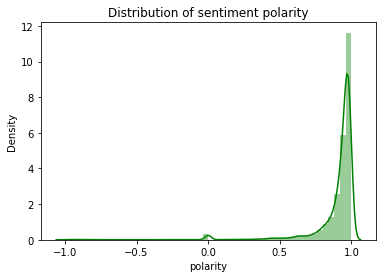

In [ ]:
sns.distplot(reviews['polarity'], norm_hist=True, color='g')
plt.title('Distribution of sentiment polarity');

## Explore correlation between other housing features and polarity score

In [ ]:
# Process on host_identity_verified, mapping true to 1 and false to 0
listing['host_identity_verified']=listing['host_identity_verified'].map({'t':1,'f':0})
listing['host_identity_verified']=listing['host_identity_verified'].fillna(int(0))
listing['host_identity_verified']=listing['host_identity_verified'].astype(int)

In [ ]:
# Process on instant_bookable, mapping true to 1 and false to 0
listing['instant_bookable']=listing['instant_bookable'].map({'t':1,'f':0})
listing['instant_bookable']=listing['instant_bookable'].fillna(int(0))
listing['instant_bookable']=listing['instant_bookable'].astype(int)

In [ ]:
# Process on cancellation_policy, mapping strict to -1,moderate to 0, flexible to 1
listing['cancellation_policy']=listing['cancellation_policy'].map({'strict':int(-1),'moderate':int(0),'flexible':int(1)})


In [ ]:
listing['cancellation_policy'].value_counts()

-1    1417
 0    1251
 1    1150
Name: cancellation_policy, dtype: int64

In [ ]:
score_listing=listing[['id', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                         'review_scores_cleanliness', 'review_scores_checkin', 
                         'review_scores_communication', 'review_scores_location', 'review_scores_value',
                         'host_identity_verified','instant_bookable','cancellation_policy']]

In [ ]:
# Drop useless columns
reviews.drop(columns=['Unnamed: 0','Unnamed: 0.1','language'],inplace=True)

In [ ]:
list_pol = pd.DataFrame(reviews.groupby(['listing_id']).mean()['polarity'])

In [ ]:
list_pol.columns=['avg_polarity']
list_pol.head(5)

,avg_polarity
listing_id,
4291,0.820251
5682,0.898638
6606,0.915527
7369,0.904622
9419,0.910130


In [ ]:
# Before calculating the correlation, we merged all relevant columns together, joining listing and reviews by a common key 'listing_id'

full = pd.merge(score_listing, list_pol, left_on='id', right_on='listing_id', how='left')
full.head(5)

,id,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_identity_verified,instant_bookable,cancellation_policy,avg_polarity
0,241032,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,1,0,0,0.894851
1,953595,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,-1,0.897614
2,3308979,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,-1,0.938842
3,7421966,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,NaN
4,278830,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,0,-1,0.842305


In [ ]:
full_clear = full.dropna()
full_clear.shape

(3158, 13)

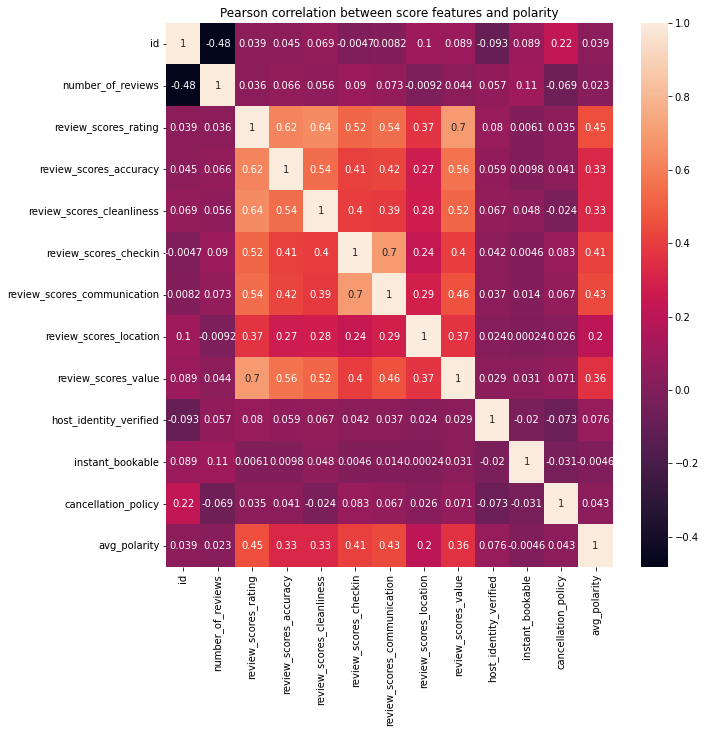

In [ ]:
# We use Pearson correlation here and with the help of seaborn, we are able to visualize the correlations by a heatmap

corr = full_clear.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.title('Pearson correlation between score features and polarity');


## Build a collaborative filtering machine

Here, we will implement latent feature model collaborative filtering. The core technique is SVD, which plays pretty well in bringing out the most useful part of data. In collaborative filtering, it can capture the underlying pattern of interests of like-minded users and uses the choices and preferences of similar users to suggest new items

In [ ]:
# Before implementing SVD, we first have to build an utility matrix where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.
# Namely, a utility matrix, where columns represent listing_id, rows are reviewer_id, and the table is populated with polarity values for known reviewer_id/listing_id pairs and NaN if unknown. 
df_rec = reviews[['reviewer_id', 'listing_id', 'polarity']]

In [ ]:
df_rec.shape

(84399, 3)

In [ ]:
y = df_rec['reviewer_id']
y.value_counts()

206203      66
15121499    32
5775807     19
2734499     19
29590276    18
            ..
28013368     1
9392956      1
11361085     1
12963958     1
1574911      1
Name: reviewer_id, Length: 75446, dtype: int64

In [ ]:
# to ensure train and test data follow the same distribution, we will stratify sampling along reviewer_id, however,
# some reviewer_id corresponds to only one record, hence we will reproduce one record for them

# Firstly, identify those with only one polarity score
pd1 = pd.DataFrame({"reviewer":y.value_counts().index,
                     "count":y.value_counts().values})
pd_temp=pd1[pd1['count']==1]
uni_reviewer=pd_temp['reviewer'].to_list()

In [ ]:
df1=df_rec[~df_rec.reviewer_id.isin(uni_reviewer)]
df2=df_rec[df_rec.reviewer_id.isin(uni_reviewer)]
df3 = pd.DataFrame(np.repeat(df2.values,5,axis=0))

df3.columns = df2.columns
df3['reviewer_id']=df3['reviewer_id'].astype(int)
df3['listing_id']=df3['listing_id'].astype(int)
df_res=df1.append(df3)

In [ ]:
#importing necessary libraries
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# split into train and test set

#Assign X as the original ratings dataframe and y as the reviewer_id column of ratings, which is unique and can ensure that we are stratifying sampling correctly
X = df_rec.copy()
y = df_rec['reviewer_id']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
# create utility matrix

matrix = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
matrix.head()


listing_id,4291,5682,6606,7369,9419,9460,9531,9534,9596,10385,...,9924107,9929059,9939359,9957555,9970805,9995551,10012724,10020221,10118341,10248139
reviewer_id,,,,,,,,,,,,,,,,,,,,,
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


we can tell from above how sparse this utility matrix is

### Weighted average method

In the 1st method, we will use the weighted avg of the ratings using cosine similarity as the weights. The users who are more similar to the input_user will have a higher weight in our rating computation for the input_user.


In [ ]:
# Let’s first replace the NULL values by 0s since the cosine_similarity doesn’t work will NA values.
matrix_dummy = matrix.copy().fillna(0)
matrix_dummy.head()


listing_id,4291,5682,6606,7369,9419,9460,9531,9534,9596,10385,...,9924107,9929059,9939359,9957555,9970805,9995551,10012724,10020221,10118341,10248139
reviewer_id,,,,,,,,,,,,,,,,,,,,,
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#cosine similarity of the ratings
similarity_matrix = cosine_similarity(matrix_dummy, matrix_dummy)
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=matrix.index, columns=matrix.index)


In [ ]:
similarity_matrix_df.shape

(75446, 75446)

In [ ]:
df=pd.DataFrame(columns=['> zero', '< zero', '== zero'])
df['> zero'] = similarity_matrix_df.gt(0).sum(axis=1)
df['< zero'] = similarity_matrix_df.lt(0).sum(axis=1)
df['== zero'] = similarity_matrix_df.eq(0).sum(axis=1)
print (df)

             > zero  < zero  == zero
reviewer_id                         
15               21       1    75424
262             177       1    75268
431             120       1    75325
1618             25       0    75421
1720             72       0    75374
...             ...     ...      ...
52713564          0       0    75446
52721080         33       0    75413
52723379          4       0    75442
52790726        106       1    75339
52812740         93       0    75353

[75446 rows x 3 columns]


In [ ]:
np.mean(df_rec['polarity'])

0.8935550717425549

In [ ]:
#calculate ratings using weighted sum of cosine similarity function to calculate ratings
def calculate_ratings(id_listing, id_user):
    if id_listing in matrix:
        cosine_scores = similarity_matrix_df[id_user]  #similarity of id_user with every other user
        ratings_scores = matrix_dummy[id_listing]      #ratings of every other user for the housing listing_id
        
        # won't consider users who havent rated id_listing so drop similarity scores and ratings corresponsing to np.nan
        index_not_rated = ratings_scores[ratings_scores.isnull()].index
        ratings_scores = ratings_scores.dropna()
        cosine_scores = cosine_scores.drop(index_not_rated)
        
        # calculating rating by weighted mean of ratings and cosine scores of the users who have rated the movie
        try:
            ratings_housing = (np.dot(ratings_scores, cosine_scores))/(cosine_scores.sum())
            if ratings_housing>1:
                ratings_housing=1
            print(ratings_housing)
            return ratings_housing
        except :
            return 0.893
    else:
        return 0.893
    

In [ ]:
#evaluates on test set
predict_ratings=[]
for index, row in X_test.iterrows():
    predict_rating=calculate_ratings(row['listing_id'],row['reviewer_id'])
    predict_ratings.append(predict_rating)



In [ ]:
pred=pd.Series(predict_ratings).fillna(0.893).tolist()
pred_df=pd.DataFrame(pred)
pred_df['score'][np.isinf(pred_df['score'])] = 0
pred_df.columns=['score']
pred_df['score']=pred_df['score'].astype(float)
pred_df[pred_df['score']<0]=0
pred=pred_df['score'].tolist()

In [ ]:
true_ratings = np.array(X_test['polarity'])
score = np.sqrt(mean_squared_error(true_ratings, pred))

In [ ]:
score

0.294066914986345

As the baseline model, Weighted average method gives us 0.29 RMSE.

### SVD

In [ ]:
# split into train and test set

#Assign X as the original ratings dataframe and y as the reviewer_id column of ratings, which is unique and can ensure that we are stratifying sampling correctly
X = df_res.copy()
y = df_res['reviewer_id']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y,random_state=42)

In [ ]:
# create utility matrix for train set and test set
matrix_train = X_train.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')
matrix_test = X_test.pivot_table(index='reviewer_id', columns='listing_id', values='polarity')


In [ ]:
from scipy.sparse.linalg import svds

# SVD will compress our sparse utility matrix into a dense one with matrix factorization technique

def recommend_predictions(matrix, k):
    """
    :param matrix: a utility matrix with polarity values for known reviewer/listing pairs
    :param k: number of features to keep for SVD

    returns the dataframe with predicted polarity values for all (user,listing) pairs
    """
    
    # keep track of reviewers and listings
    reviewer_rows = list(matrix.index)
    reviewer_index = {reviewer_rows[i]: i for i in range(len(reviewer_rows))}
    listing_cols = list(matrix.columns)
    listing_index = {listing_cols[i]: i for i in range(len(listing_cols))}

    # mask NaN and remove means
    mask = np.isnan(matrix)
    masked_arr = np.ma.masked_array(matrix, mask)
    item_means = np.mean(masked_arr, axis=0) 
    
    # NaN entries will be replaced by the average rating for each item
    util_mat = masked_arr.filled(item_means)
    means = np.tile(item_means, (util_mat.shape[0],1))
    util_mat_normal = util_mat - means

    # run SVD
    U, sigma, Vt = svds(util_mat_normal, k = k)
    sigma = np.diag(sigma)  
    all_predicted_polarity = np.dot(np.dot(U, sigma), Vt) + means

    return all_predicted_polarity, reviewer_index, listing_index

In [ ]:
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error

In [ ]:
pred,index_re,index_list = recommend_predictions(matrix_train, k=50) #k is a hyperparameter

this_pred = [] #to store the predicted ratings
for i, row in X_test.iterrows():
    user = row['reviewer_id']
    item = row['listing_id']
    
    try:
        u_index = index_re[user]
        if item in index_list:
            i_index = index_list[item]
            pred_rating = pred[u_index, i_index]
        else:
            
            pred_rating = np.mean(pred[u_index, :])
        this_pred.append(pred_rating)
        
    except:
        print('error with user', user, 'at index', i)
rmse=np.sqrt(mean_squared_error(X_test['polarity'], this_pred))
rmse

0.17902600578432962

In [ ]:
# try different values of k, grid search

no_of_features = [70, 100, 120, 150]
rmse= []

for k in no_of_features:
    
    pred,index_re,index_list = recommend_predictions(matrix_train, k=k)
    
    this_pred = [] #to store the predicted ratings
    for i, row in X_test.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = index_re[user]
            if item in index_list:
                i_index = index_list[item]
                pred_rating = pred[u_index, i_index]
            else:
                pred_rating = np.mean(pred[u_index, :])
            this_pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)
            continue

    rmse_i = np.sqrt(mean_squared_error(X_test['polarity'], this_pred))
    rmse.append(rmse_i)
    
    print(k, rmse_i)

70 0.17420482479014623
100 0.16830151192449466
120 0.1645972159367225
150 0.1594687140005812


As we can see from the above result, the best choice of hyperparameter-'no_of_features' is 150, which is intuitive, more information we keep, more accurate our prediction can be.
Plus, SVD does provide us with a better result, 0.16 RMSE, compared to 0.29 from simple weighted average.

## Make recommendations for a particular user

In [ ]:
listing_id_array = df_rec['listing_id'].unique()

def get_recommendations(predMat, reviewer, N):
    """
    predMat: predicted matrix
    reviewer: selected reviewer_id
    N: top N recommendations
    
    return top N recommendations for specified user
    """
    u_index = index_re[reviewer]
    item_i = [index_list[listing_id_array[i]] for i in range(len(listing_id_array))]
    
    pred_user = [predMat[u_index, i_index] for i_index in item_i]
    
    d = {'listing_id': listing_id_array, 'predicted_polarity': pred_user}
    user_rec = pd.DataFrame(data=d)
    user_rec.sort_values(by=['predicted_polarity'], ascending=False, inplace=True)
    user_rec.reset_index(inplace=True, drop=True)
    
    return user_rec[:N]

In [ ]:
# using mat from SVD method

user_rec = get_recommendations(pred, df_rec['reviewer_id'][0], 10)
user_rec.style.bar(subset=['predicted_polarity'], align='mid')

,listing_id,predicted_polarity
0,9367465,0.996800
1,6022715,0.996700
2,3888986,0.996000
3,5968862,0.995800
4,9522082,0.995300
5,8483744,0.994700
6,3593582,0.994600
7,8988178,0.994300
8,8508223,0.993200
9,9151865,0.993000
